# Import librairies

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Load data

In [2]:
train_data_rio = pd.read_csv('station_rio.csv')

In [3]:
train_data_rio.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,27.45,24.87,21.98,22.33,24.16
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54,26.56,24.42,21.24,23.41,23.91
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53,25.58,23.54,21.05,23.05,23.31
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56,26.74,24.18,20.82,22.58,23.58
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84,27.07,24.48,22.50,23.61,24.42


In [4]:
train_data_rio.shape

(47, 18)

In [5]:
train_data_rio = pd.read_csv('station_rio.csv')

In [6]:
train_data_rio.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,27.45,24.87,21.98,22.33,24.16
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54,26.56,24.42,21.24,23.41,23.91
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53,25.58,23.54,21.05,23.05,23.31
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56,26.74,24.18,20.82,22.58,23.58
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84,27.07,24.48,22.50,23.61,24.42


In [7]:
train_data_rio.shape

(47, 18)

# Pré-processamento dos dados

In [8]:
months_dict = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6, 'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

train_data_rio = train_data_rio[['YEAR'] + list(months_dict.keys())]
train_data_rio.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84


In [9]:
df_rio = pd.melt(train_data_rio, 
        id_vars='YEAR',
        value_vars=months_dict.keys(),
        var_name='MONTH', 
        value_name='Sum of Value').replace({"MONTH": months_dict}) # replaces month names to month numbers.

df_rio.head()

,YEAR,MONTH,Sum of Value
0,1973,1,27.73
1,1974,1,26.68
2,1975,1,25.27
3,1976,1,27.48
4,1977,1,27.13


In [10]:
df_rio["DAY"] = 1
df_rio['DATE'] = pd.to_datetime(df_rio[['YEAR','MONTH','DAY']])
df_rio = df_rio.rename(columns = {'Sum of Value':'TEMP'})
df_rio = df_rio.sort_values("DATE").reset_index(drop=True)

df_rio = df_rio.drop(["YEAR", "MONTH", "DAY"], axis = 1)
df_rio = df_rio.set_index('DATE', drop = True)

In [11]:
df_rio.head()

,TEMP
DATE,
1973-01-01,27.73
1973-02-01,27.97
1973-03-01,25.70
1973-04-01,26.49
1973-05-01,22.42


In [12]:
df_rio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564 entries, 1973-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    564 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


## _Interpolate Data
Há dados faltantes, esta parte do código é para cobrir estes dados por interpolação

In [13]:
print(df_rio["TEMP"].min(), df_rio["TEMP"].max(), df_rio["TEMP"].mean())

19.24 999.9 105.56517730496454


In [14]:
df_rio.replace(999.90, np.nan, inplace = True)
df_rio_intp = df_rio.interpolate()

In [15]:
print(df_rio_intp["TEMP"].min(), df_rio_intp["TEMP"].max(), df_rio_intp["TEMP"].mean())

19.24 30.25 24.390939716312058


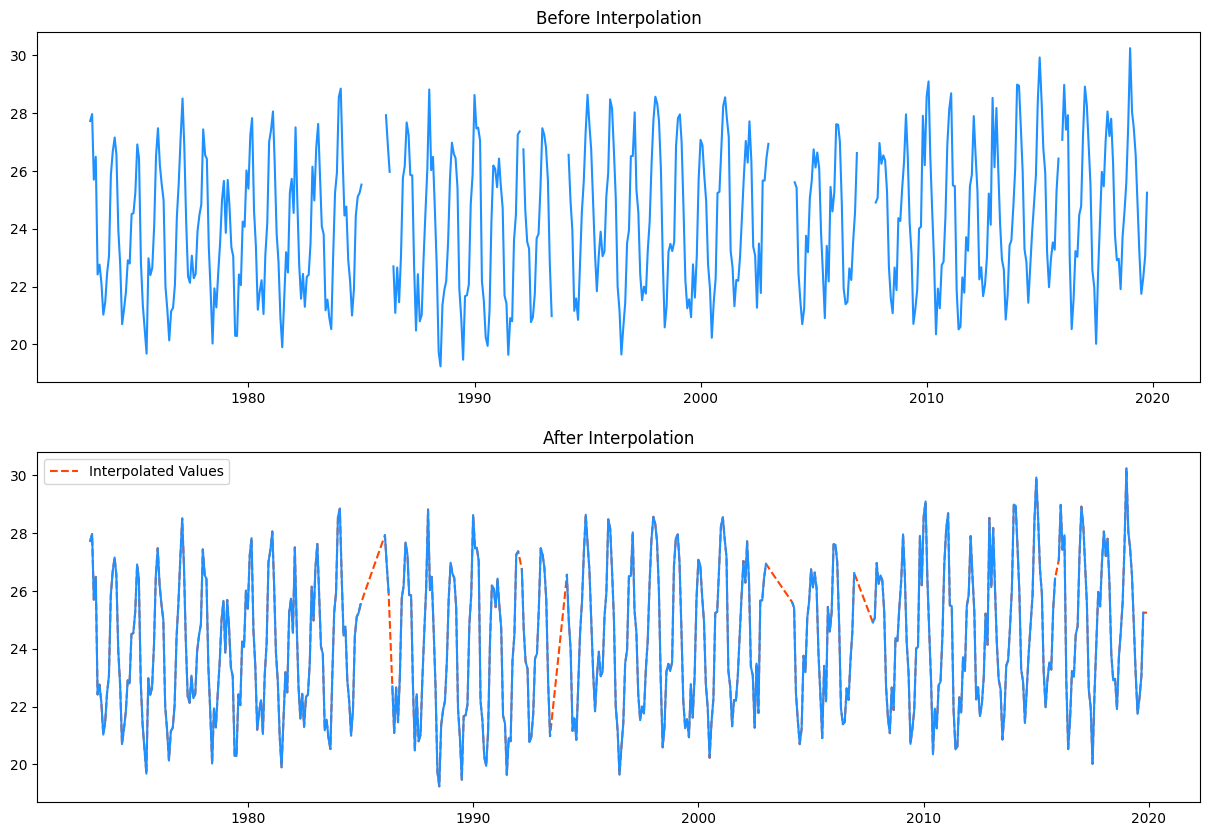

In [16]:
rows = 2
cols = 1

fig, axs = plt.subplots(2, figsize = (15, 10))

axs[0]
axs[0].set_title('Before Interpolation')
axs[0].plot(df_rio, color = 'dodgerblue')

axs[1].plot(df_rio_intp, color = 'orangered', linestyle = '--', label = 'Interpolated Values')
legend = plt.legend(loc = 'upper left')
axs[1].set_title("After Interpolation")
axs[1].plot(df_rio, color = 'dodgerblue')

plt.show()

## _Scaling - Aqui está padronizando os dados

In [17]:
temp = df_rio_intp.filter(["TEMP"])
temp_values = temp.values

In [18]:
# scaler = MinMaxScaler(feature_range = (0,1))
# scaled_data = scaler.fit_transform(temp_values)

In [19]:
scaled_data = temp_values

In [20]:
scaled_data.shape

(564, 1)

In [21]:
scaled_data[:5]

array([[27.73],
       [27.97],
       [25.7 ],
       [26.49],
       [22.42]])

In [22]:
df_rio_intp.head(5)

,TEMP
DATE,
1973-01-01,27.73
1973-02-01,27.97
1973-03-01,25.70
1973-04-01,26.49
1973-05-01,22.42


# Train test split

In [23]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [24]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


In [25]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [26]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [27]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = temp_values[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


In [28]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
y_valid length: 24
X_test length: 86
Y_test length: 86


# Decomposição da Série

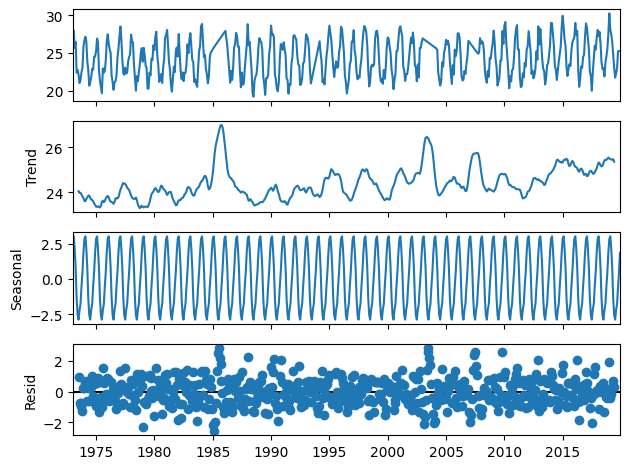

In [29]:
# Additive model
res = sm.tsa.seasonal_decompose(df_rio_intp,period=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [30]:
# Stationarity tests
def test_stationarity(df_rio_intp):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df_rio_intp, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_rio_intp)

Results of Dickey-Fuller Test:
Test Statistic                  -5.174339
p-value                          0.000010
#Lags Used                      15.000000
Number of Observations Used    548.000000
Critical Value (1%)             -3.442339
Critical Value (5%)             -2.866829
Critical Value (10%)            -2.569587
dtype: float64


# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [66]:
epochs = 10
batch = 32
lr = 0.001
adam = optimizers.Adam(lr)

In [67]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=adam)
model_mlp.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
mlp_history = model_mlp.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/10
11/11 - 1s - 129ms/step - loss: 54.3582 - val_loss: 4.3713
Epoch 2/10
11/11 - 0s - 7ms/step - loss: 11.4182 - val_loss: 8.1276
Epoch 3/10
11/11 - 0s - 14ms/step - loss: 6.2821 - val_loss: 3.9172
Epoch 4/10
11/11 - 0s - 7ms/step - loss: 4.5642 - val_loss: 2.1585
Epoch 5/10
11/11 - 0s - 18ms/step - loss: 3.5811 - val_loss: 1.7481
Epoch 6/10
11/11 - 0s - 6ms/step - loss: 3.0457 - val_loss: 1.5487
Epoch 7/10
11/11 - 0s - 6ms/step - loss: 2.7036 - val_loss: 1.4054
Epoch 8/10
11/11 - 0s - 6ms/step - loss: 2.4688 - val_loss: 1.2988
Epoch 9/10
11/11 - 0s - 7ms/step - loss: 2.3131 - val_loss: 1.2498
Epoch 10/10
11/11 - 0s - 7ms/step - loss: 2.2174 - val_loss: 1.2271


In [69]:
model_reg = Sequential()
model_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_reg.add(Dense(1))  # Saída
model_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
model_reg.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
mlp_reg_history = model_reg.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/10
11/11 - 1s - 121ms/step - loss: 333.9117 - val_loss: 120.7329
Epoch 2/10
11/11 - 0s - 10ms/step - loss: 58.2198 - val_loss: 20.8524
Epoch 3/10
11/11 - 0s - 29ms/step - loss: 24.5757 - val_loss: 9.4556
Epoch 4/10
11/11 - 0s - 8ms/step - loss: 12.9288 - val_loss: 7.9387
Epoch 5/10
11/11 - 0s - 7ms/step - loss: 9.8479 - val_loss: 7.4909
Epoch 6/10
11/11 - 0s - 8ms/step - loss: 8.4192 - val_loss: 7.2580
Epoch 7/10
11/11 - 0s - 6ms/step - loss: 7.8296 - val_loss: 6.9108
Epoch 8/10
11/11 - 0s - 6ms/step - loss: 7.2532 - val_loss: 6.5032
Epoch 9/10
11/11 - 0s - 6ms/step - loss: 6.8918 - val_loss: 6.2962
Epoch 10/10
11/11 - 0s - 9ms/step - loss: 6.4466 - val_loss: 5.8532


In [71]:
model_dropout = Sequential()
model_dropout.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_dropout.add(Dropout(0.5))  # 50% de dropout
model_dropout.add(Dense(32, activation='relu'))
model_dropout.add(Dropout(0.5))  # 50% de dropout
model_dropout.add(Dense(1))  # Saída
model_dropout.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
model_dropout.summary()



Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
mlp_drop_history = model_dropout.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/10
11/11 - 2s - 209ms/step - loss: 1898.9272 - val_loss: 10.4136
Epoch 2/10
11/11 - 0s - 7ms/step - loss: 479.5585 - val_loss: 9.1620
Epoch 3/10
11/11 - 0s - 7ms/step - loss: 292.7839 - val_loss: 53.5636
Epoch 4/10
11/11 - 0s - 7ms/step - loss: 223.6089 - val_loss: 78.2489
Epoch 5/10
11/11 - 0s - 10ms/step - loss: 190.5683 - val_loss: 47.8486
Epoch 6/10
11/11 - 0s - 7ms/step - loss: 158.4972 - val_loss: 29.6484
Epoch 7/10
11/11 - 0s - 7ms/step - loss: 149.5793 - val_loss: 71.3940
Epoch 8/10
11/11 - 0s - 9ms/step - loss: 140.9713 - val_loss: 71.5325
Epoch 9/10
11/11 - 0s - 6ms/step - loss: 134.7403 - val_loss: 45.7955
Epoch 10/10
11/11 - 0s - 6ms/step - loss: 116.1298 - val_loss: 54.9338


## Comparando os 3 modelos

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    return mae, mse, rmse

# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg = evaluate_model(model_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout = evaluate_model(model_dropout, X_test, Y_test, "Modelo com Dropout")

# Comparação dos resultados (opcional)
print("\nComparação de resultados:")
print(f"Modelo Padrão - MAE: {mae_standard:.4f}, RMSE: {rmse_standard:.4f}")
print(f"Modelo com Regularização - MAE: {mae_reg:.4f}, RMSE: {rmse_reg:.4f}")
print(f"Modelo com Dropout - MAE: {mae_dropout:.4f}, RMSE: {rmse_dropout:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Modelo Padrão:
MAE: 1.0691
MSE: 1.8934
RMSE: 1.3760
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Modelo com Regularização:
MAE: 2.0210
MSE: 5.9716
RMSE: 2.4437
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Modelo com Dropout:
MAE: 7.9569
MSE: 69.1554
RMSE: 8.3160

Comparação de resultados:
Modelo Padrão - MAE: 1.0691, RMSE: 1.3760
Modelo com Regularização - MAE: 2.0210, RMSE: 2.4437
Modelo com Dropout - MAE: 7.9569, RMSE: 8.3160


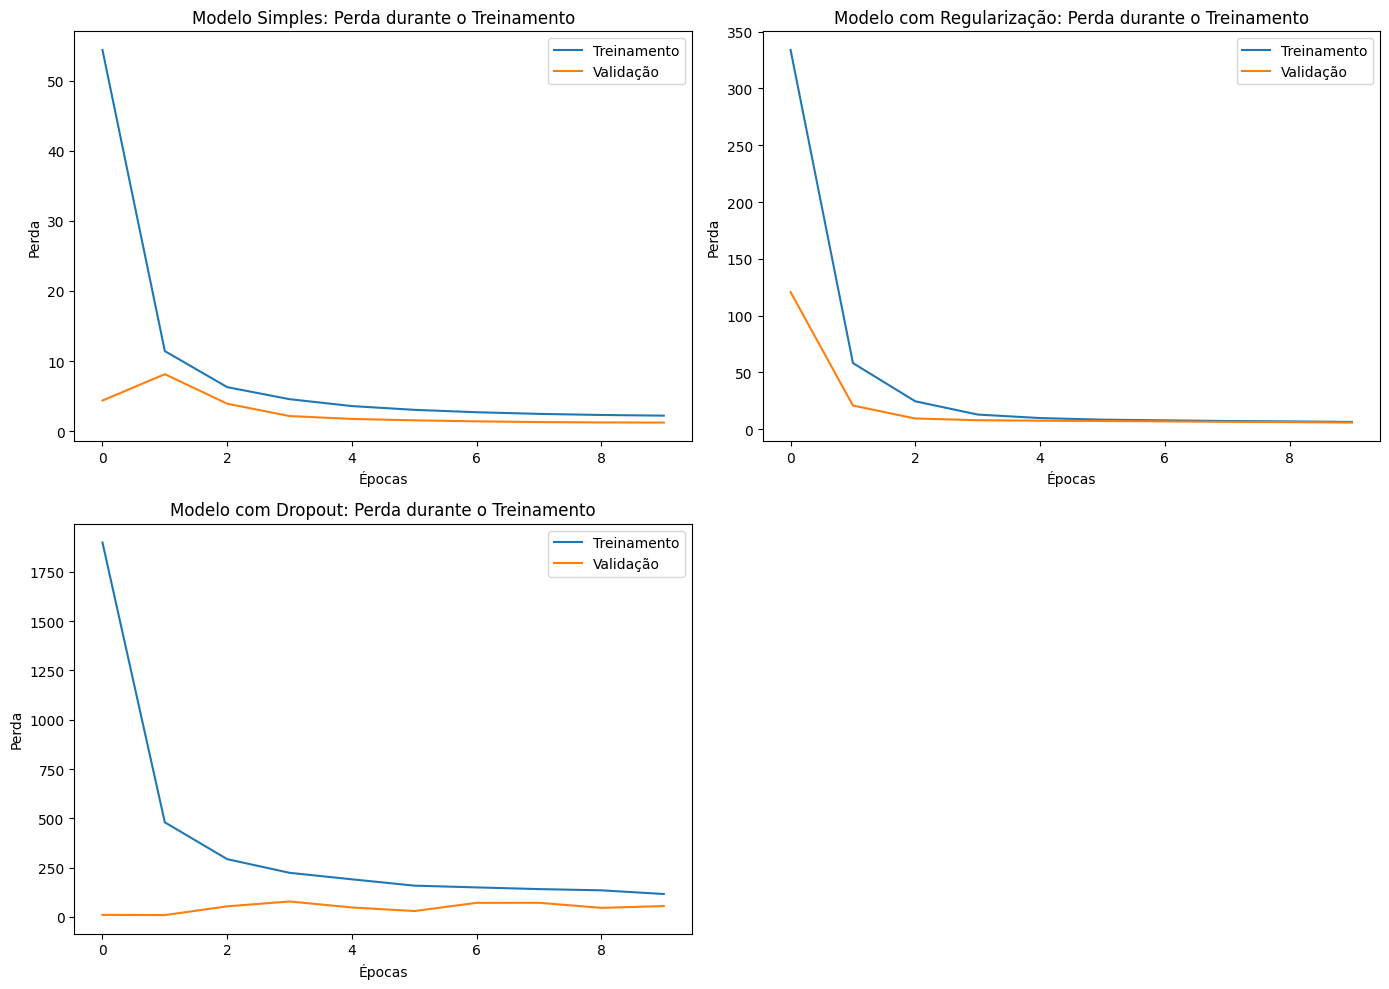

In [113]:
# Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(mlp_history.history['loss'], label='Treinamento')
plt.plot(mlp_history.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(mlp_reg_history.history['loss'], label='Treinamento')
plt.plot(mlp_reg_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(mlp_drop_history.history['loss'], label='Treinamento')
plt.plot(mlp_drop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# # Modelo com Regularização e Dropout
# plt.subplot(2, 2, 4)
# plt.plot(cnn_regdrop_history.history['loss'], label='Treinamento')
# plt.plot(cnn_regdrop_history.history['val_loss'], label='Validação')
# plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
# plt.xlabel('Épocas')
# plt.ylabel('Perda')
# plt.legend()

plt.tight_layout()
plt.show()

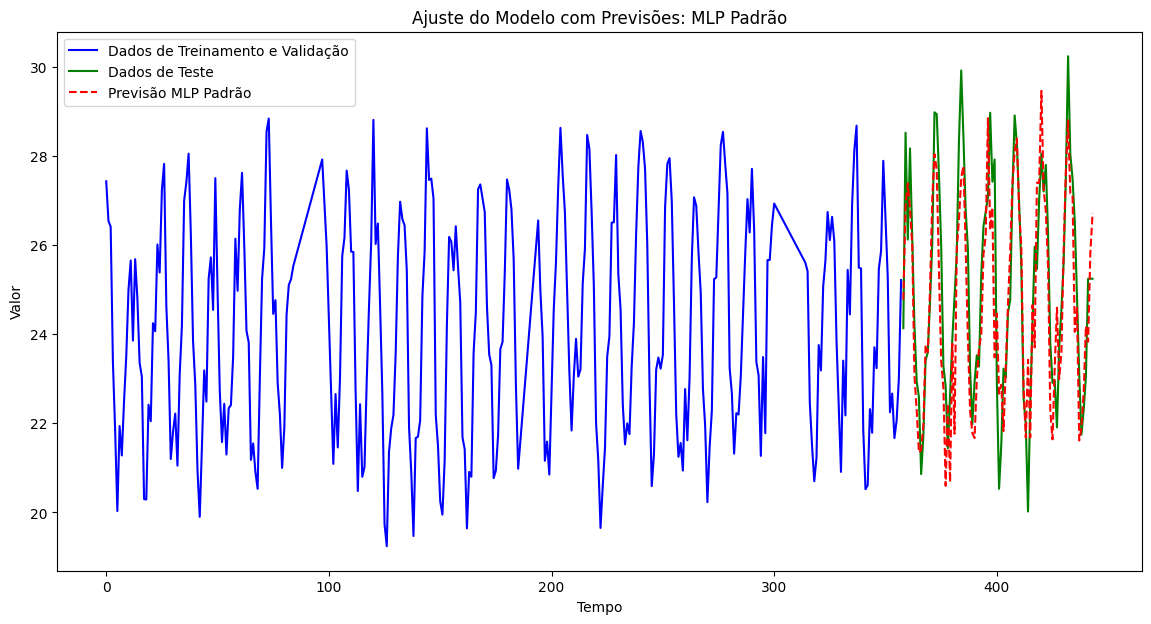

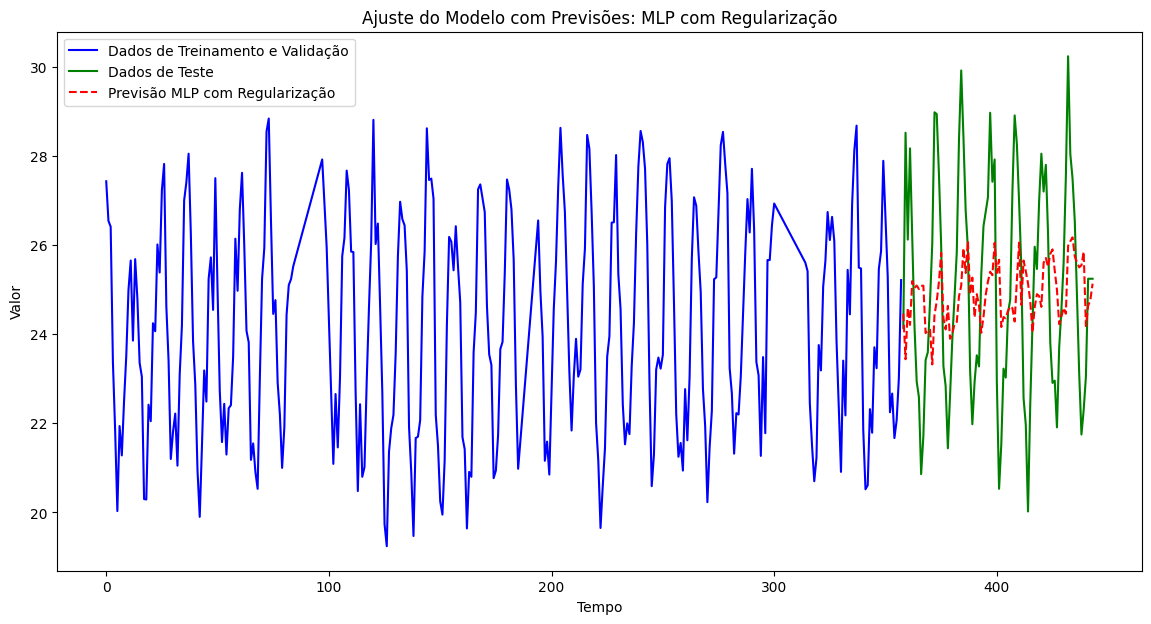

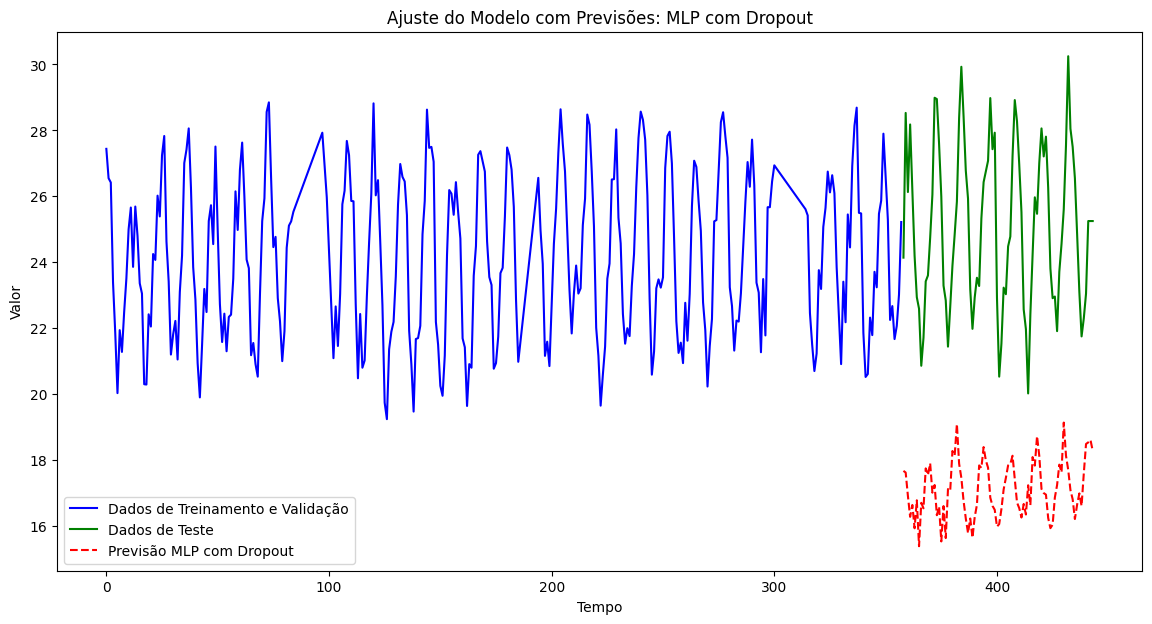

In [75]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

def plot_fit_with_predictions(train_valid_data, y_test, y_pred, model_name):
    plt.figure(figsize=(14, 7))
    
    # Plot dos dados de treino e validação
    plt.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
    
    # Plot dos dados de teste
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
    
    # Plot das previsões
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
    
    plt.title(f"Ajuste do Modelo com Previsões: {model_name}")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

# Plot do ajuste e previsão para cada modelo
plot_fit_with_predictions(train_valid_data, Y_test, y_pred_mlp, "MLP Padrão")
plot_fit_with_predictions(train_valid_data, Y_test, y_pred_reg, "MLP com Regularização")
plot_fit_with_predictions(train_valid_data, Y_test, y_pred_drop, "MLP com Dropout")

# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [86]:
#Hiperparametros
epochs = 20
batch = 32
lr = 0.001
#adam = optimizers.Adam(lr)


In [105]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (334, 60, 1)
Validation set shape (24, 60, 1)
Test set shape (86, 60, 1)


## Aplicando Modelo CNN

In [88]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 59, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 50)             │        92,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,093 (363.64 KB)

 Trainable params: 93,093 (363.64 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
cnn_history = model_cnn.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/50
11/11 - 2s - 153ms/step - loss: 116.8222 - val_loss: 12.0047
Epoch 2/50
11/11 - 0s - 9ms/step - loss: 21.2672 - val_loss: 15.4280
Epoch 3/50
11/11 - 0s - 15ms/step - loss: 9.7362 - val_loss: 7.7284
Epoch 4/50
11/11 - 0s - 9ms/step - loss: 6.8667 - val_loss: 7.3803
Epoch 5/50
11/11 - 0s - 9ms/step - loss: 4.9902 - val_loss: 4.3840
Epoch 6/50
11/11 - 0s - 9ms/step - loss: 4.1798 - val_loss: 3.9717
Epoch 7/50
11/11 - 0s - 9ms/step - loss: 3.7873 - val_loss: 3.8937
Epoch 8/50
11/11 - 0s - 15ms/step - loss: 3.2811 - val_loss: 3.2799
Epoch 9/50
11/11 - 0s - 9ms/step - loss: 2.9209 - val_loss: 2.9050
Epoch 10/50
11/11 - 0s - 15ms/step - loss: 2.6834 - val_loss: 2.6787
Epoch 11/50
11/11 - 0s - 10ms/step - loss: 2.4776 - val_loss: 2.4708
Epoch 12/50
11/11 - 0s - 9ms/step - loss: 2.3022 - val_loss: 2.2691
Epoch 13/50
11/11 - 0s - 10ms/step - loss: 2.1670 - val_loss: 2.0994
Epoch 14/50
11/11 - 0s - 16ms/step - loss: 2.0678 - val_loss: 1.9642
Epoch 15/50
11/11 - 0s - 10ms/step - loss: 1

## Aplicando Regularização

In [89]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_reg.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 59, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 50)             │        92,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,093 (363.64 KB)

 Trainable params: 93,093 (363.64 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
cnn_reg_history = model_cnn_reg.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/20
11/11 - 2s - 182ms/step - loss: 50.1435 - val_loss: 24.7016
Epoch 2/20
11/11 - 0s - 10ms/step - loss: 11.8701 - val_loss: 8.2504
Epoch 3/20
11/11 - 0s - 14ms/step - loss: 5.7553 - val_loss: 4.2767
Epoch 4/20
11/11 - 0s - 12ms/step - loss: 3.8891 - val_loss: 2.9164
Epoch 5/20
11/11 - 0s - 8ms/step - loss: 3.0497 - val_loss: 2.4163
Epoch 6/20
11/11 - 0s - 14ms/step - loss: 2.7319 - val_loss: 2.8880
Epoch 7/20
11/11 - 0s - 9ms/step - loss: 2.8359 - val_loss: 2.1082
Epoch 8/20
11/11 - 0s - 9ms/step - loss: 3.1889 - val_loss: 2.5422
Epoch 9/20
11/11 - 0s - 10ms/step - loss: 2.8429 - val_loss: 2.3777
Epoch 10/20
11/11 - 0s - 9ms/step - loss: 3.3685 - val_loss: 6.1394
Epoch 11/20
11/11 - 0s - 12ms/step - loss: 4.0754 - val_loss: 2.2271
Epoch 12/20
11/11 - 0s - 11ms/step - loss: 3.8806 - val_loss: 2.0873
Epoch 13/20
11/11 - 0s - 9ms/step - loss: 2.7097 - val_loss: 1.5809
Epoch 14/20
11/11 - 0s - 10ms/step - loss: 2.1984 - val_loss: 1.6997
Epoch 15/20
11/11 - 0s - 13ms/step - loss: 2

## Aplicando Dropout

In [91]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada de pooling
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada densa
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_drop.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 59, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 50)             │        92,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,093 (363.64 KB)

 Trainable params: 93,093 (363.64 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
cnn_drop_history = model_cnn_drop.fit(X_train_series, Y_train, 
                                       validation_data=(X_valid_series, Y_valid), 
                                       epochs=epochs, 
                                       verbose=2)


Epoch 1/20
11/11 - 2s - 213ms/step - loss: 159.2682 - val_loss: 66.1397
Epoch 2/20
11/11 - 0s - 10ms/step - loss: 90.2614 - val_loss: 33.0926
Epoch 3/20
11/11 - 0s - 9ms/step - loss: 68.3566 - val_loss: 9.6364
Epoch 4/20
11/11 - 0s - 9ms/step - loss: 68.9049 - val_loss: 7.2639
Epoch 5/20
11/11 - 0s - 24ms/step - loss: 63.2738 - val_loss: 6.8640
Epoch 6/20
11/11 - 0s - 18ms/step - loss: 58.0351 - val_loss: 12.0052
Epoch 7/20
11/11 - 0s - 9ms/step - loss: 44.9065 - val_loss: 19.3583
Epoch 8/20
11/11 - 0s - 9ms/step - loss: 55.7325 - val_loss: 23.1727
Epoch 9/20
11/11 - 0s - 9ms/step - loss: 57.1290 - val_loss: 4.1462
Epoch 10/20
11/11 - 0s - 9ms/step - loss: 51.4505 - val_loss: 16.7538
Epoch 11/20
11/11 - 0s - 9ms/step - loss: 47.1685 - val_loss: 17.8392
Epoch 12/20
11/11 - 0s - 9ms/step - loss: 46.3773 - val_loss: 2.6827
Epoch 13/20
11/11 - 0s - 19ms/step - loss: 48.2690 - val_loss: 6.2906
Epoch 14/20
11/11 - 0s - 10ms/step - loss: 49.3437 - val_loss: 14.4809
Epoch 15/20
11/11 - 0s - 9m

## Aplicando Regularização e Dropout combinados

In [93]:
model_cnn_regdrop = Sequential()
model_cnn_regdrop.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_regdrop.add(MaxPooling1D(pool_size=2))
model_cnn_regdrop.add(Dropout(0.5))
model_cnn_regdrop.add(Flatten())
model_cnn_regdrop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_regdrop.add(Dropout(0.5))
model_cnn_regdrop.add(Dense(1))
model_cnn_regdrop.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_regdrop.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 59, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 50)             │        92,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,093 (363.64 KB)

 Trainable params: 93,093 (363.64 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
cnn_regdrop_history = model_cnn_regdrop.fit(X_train_series, Y_train, 
                                             validation_data=(X_valid_series, Y_valid), 
                                             epochs=epochs, 
                                             verbose=2)


Epoch 1/20
11/11 - 2s - 187ms/step - loss: 181.7379 - val_loss: 126.8648
Epoch 2/20
11/11 - 0s - 9ms/step - loss: 81.9261 - val_loss: 7.8264
Epoch 3/20
11/11 - 0s - 10ms/step - loss: 68.3959 - val_loss: 10.3508
Epoch 4/20
11/11 - 0s - 12ms/step - loss: 55.8703 - val_loss: 18.7670
Epoch 5/20
11/11 - 0s - 9ms/step - loss: 44.8121 - val_loss: 6.1324
Epoch 6/20
11/11 - 0s - 12ms/step - loss: 48.9641 - val_loss: 8.3827
Epoch 7/20
11/11 - 0s - 19ms/step - loss: 45.8451 - val_loss: 15.6977
Epoch 8/20
11/11 - 0s - 14ms/step - loss: 45.3236 - val_loss: 4.0934
Epoch 9/20
11/11 - 0s - 9ms/step - loss: 42.2103 - val_loss: 4.5934
Epoch 10/20
11/11 - 0s - 11ms/step - loss: 44.3254 - val_loss: 11.0578
Epoch 11/20
11/11 - 0s - 10ms/step - loss: 40.4485 - val_loss: 8.5845
Epoch 12/20
11/11 - 0s - 12ms/step - loss: 46.4970 - val_loss: 6.6264
Epoch 13/20
11/11 - 0s - 8ms/step - loss: 46.3695 - val_loss: 4.1384
Epoch 14/20
11/11 - 0s - 9ms/step - loss: 42.1427 - val_loss: 4.7681
Epoch 15/20
11/11 - 0s - 9

## Preivsao dos Modelos

In [121]:
# Previsões
predictions_simple = model_cnn.predict(X_test)
predictions_reg = model_cnn_reg.predict(X_test)
predictions_drop = model_cnn_drop.predict(X_test)
predictions_regdrop = model_cnn_regdrop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [122]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo Simples": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_simple),
        "MSE": mean_squared_error(Y_test, predictions_simple),
        "RMSE": root_mean_squared_error(Y_test, predictions_simple)
    },
    "Modelo com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_reg),
        "MSE": mean_squared_error(Y_test, predictions_reg),
        "RMSE": root_mean_squared_error(Y_test, predictions_reg)
    },
    "Modelo com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_drop),
        "MSE": mean_squared_error(Y_test, predictions_drop),
        "RMSE": root_mean_squared_error(Y_test, predictions_drop)
    },
    "Modelo com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_regdrop),
        "MSE": mean_squared_error(Y_test, predictions_regdrop),
        "RMSE": root_mean_squared_error(Y_test, predictions_regdrop)
    }
}

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}")


Modelo Simples: MAPE=128.41%, MSE=1037.1091, RMSE=32.2042
Modelo com Regularização: MAPE=3.23%, MSE=1.0737, RMSE=1.0362
Modelo com Dropout: MAPE=9.25%, MSE=7.0081, RMSE=2.6473
Modelo com Regularização e Dropout: MAPE=8.37%, MSE=5.9721, RMSE=2.4438


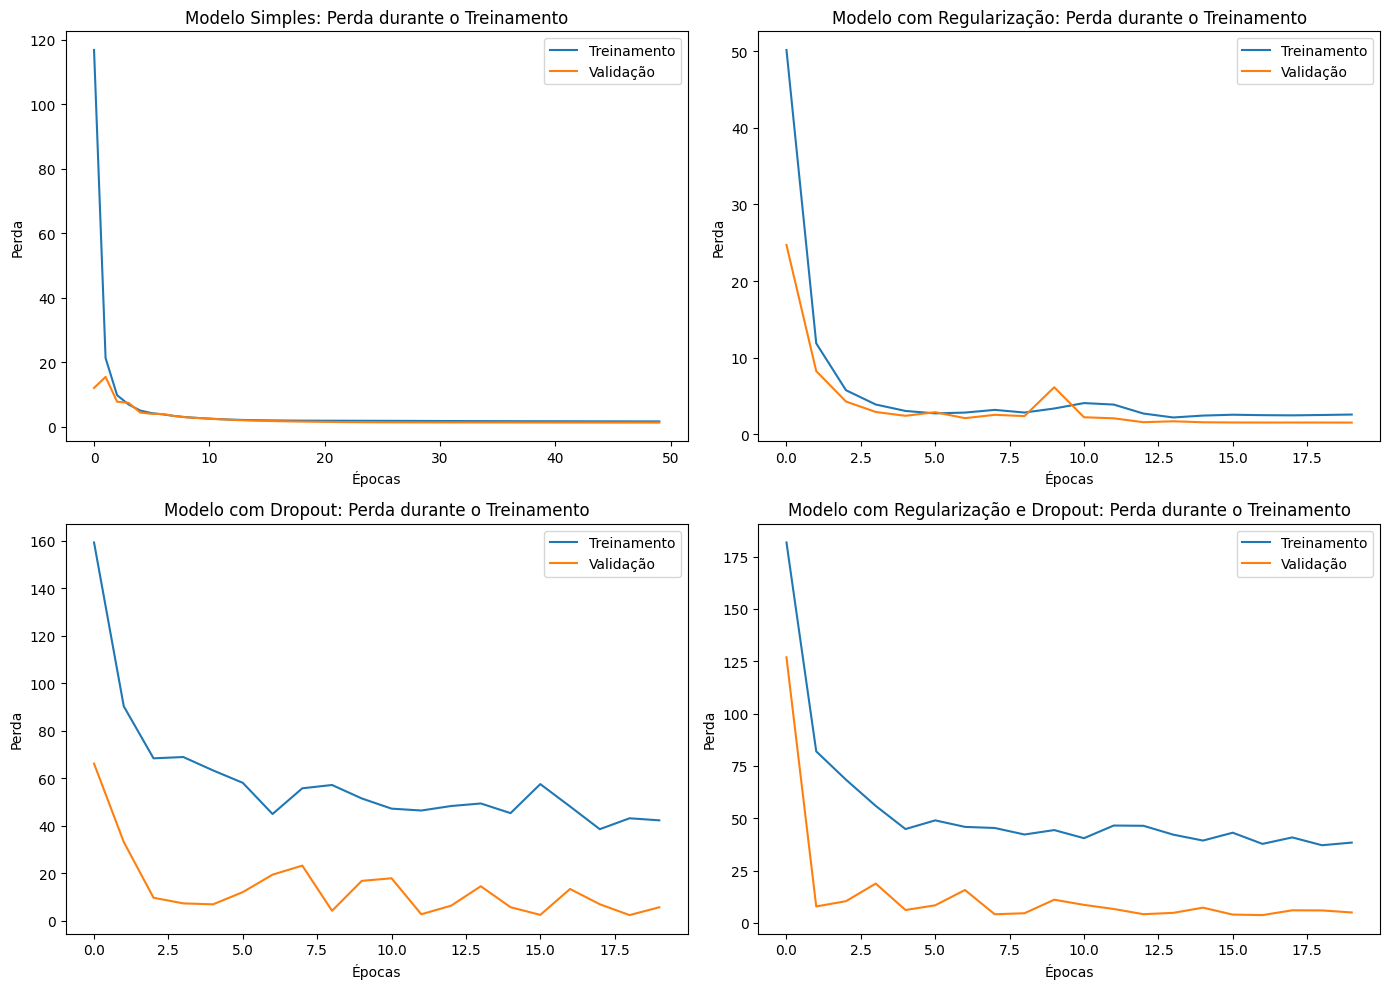

In [123]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(cnn_history.history['loss'], label='Treinamento')
plt.plot(cnn_history.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(cnn_reg_history.history['loss'], label='Treinamento')
plt.plot(cnn_reg_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(cnn_drop_history.history['loss'], label='Treinamento')
plt.plot(cnn_drop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(cnn_regdrop_history.history['loss'], label='Treinamento')
plt.plot(cnn_regdrop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


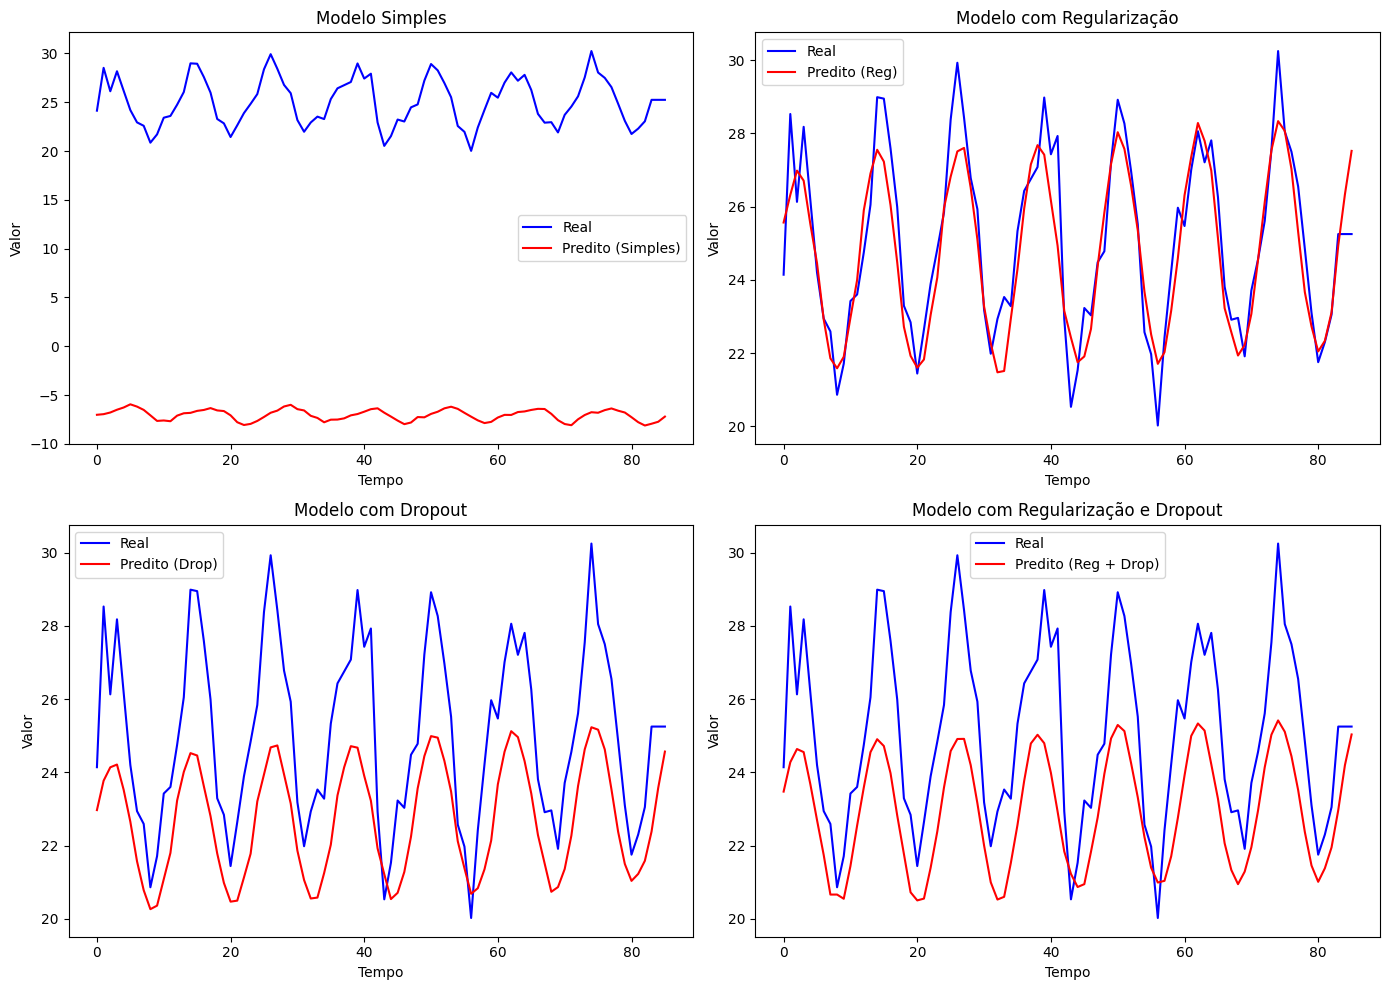

In [124]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_simple, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_regdrop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Gráficos de ajuste no conjunto de treinamento e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_simple)), predictions_simple, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo Simples: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_reg)), predictions_reg, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Regularização: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_drop)), predictions_drop, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Dropout: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_regdrop)), predictions_regdrop, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Regularização e Dropout: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


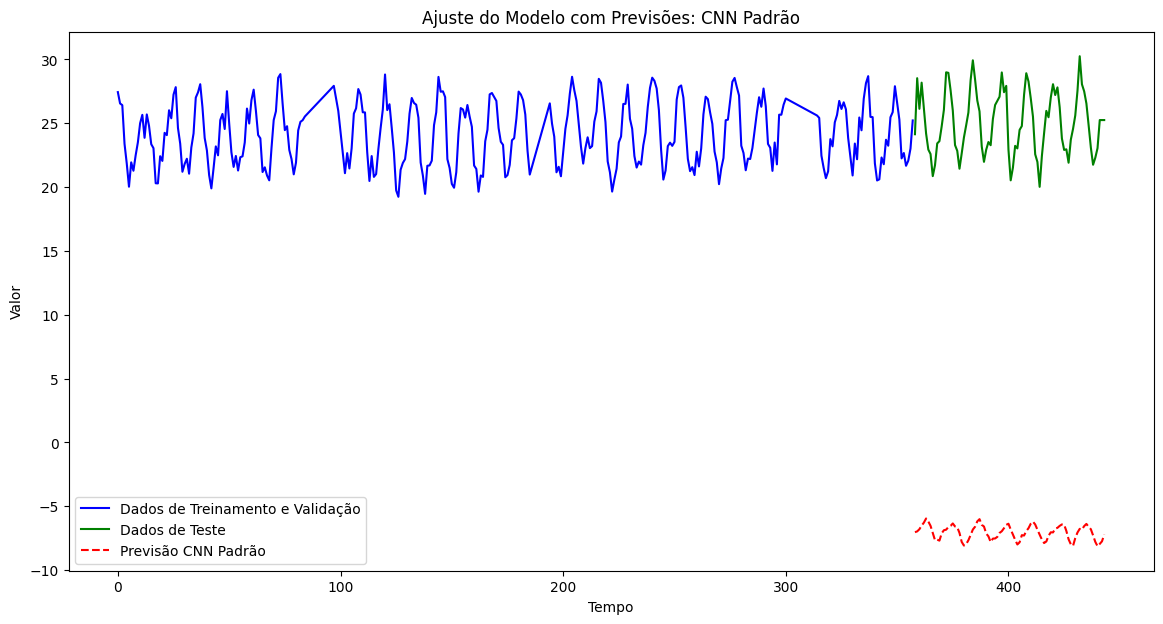

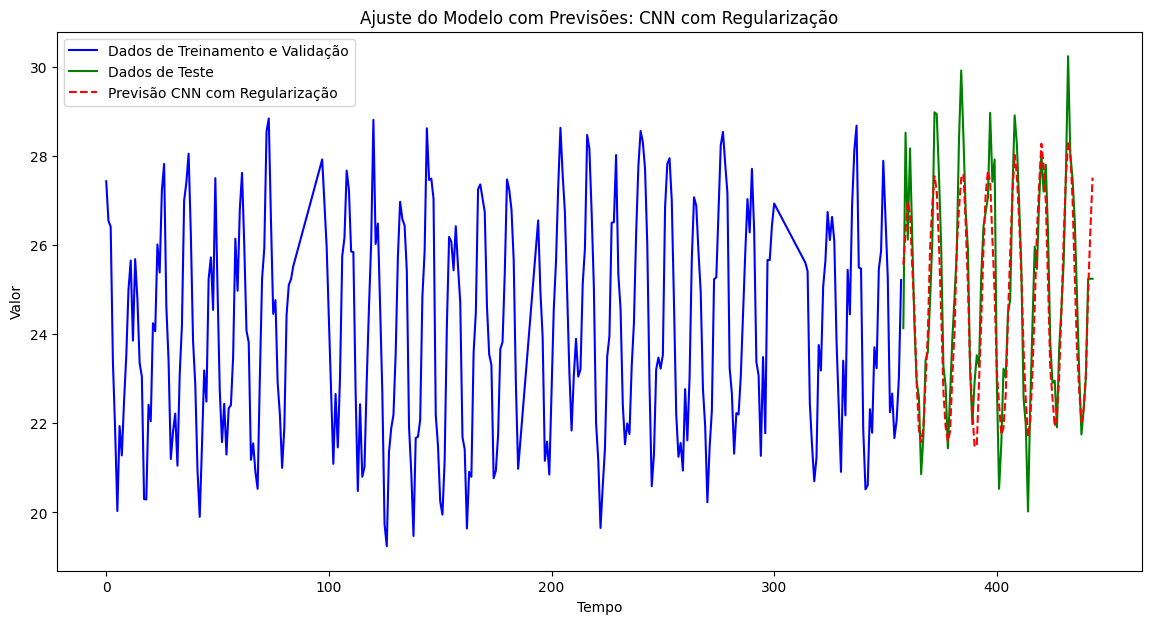

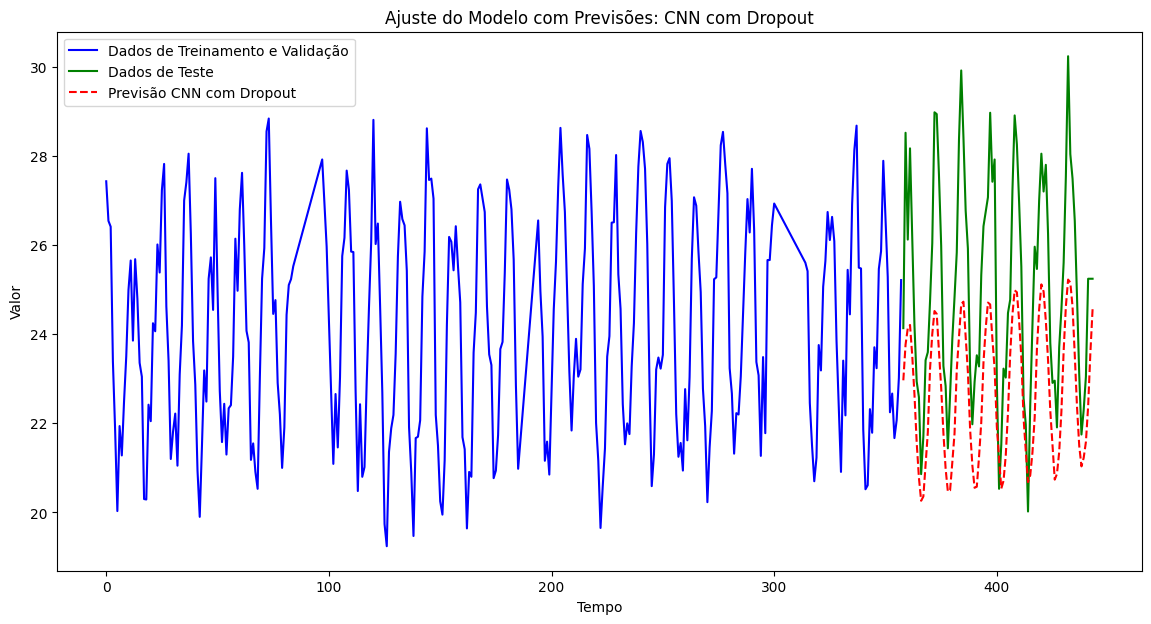

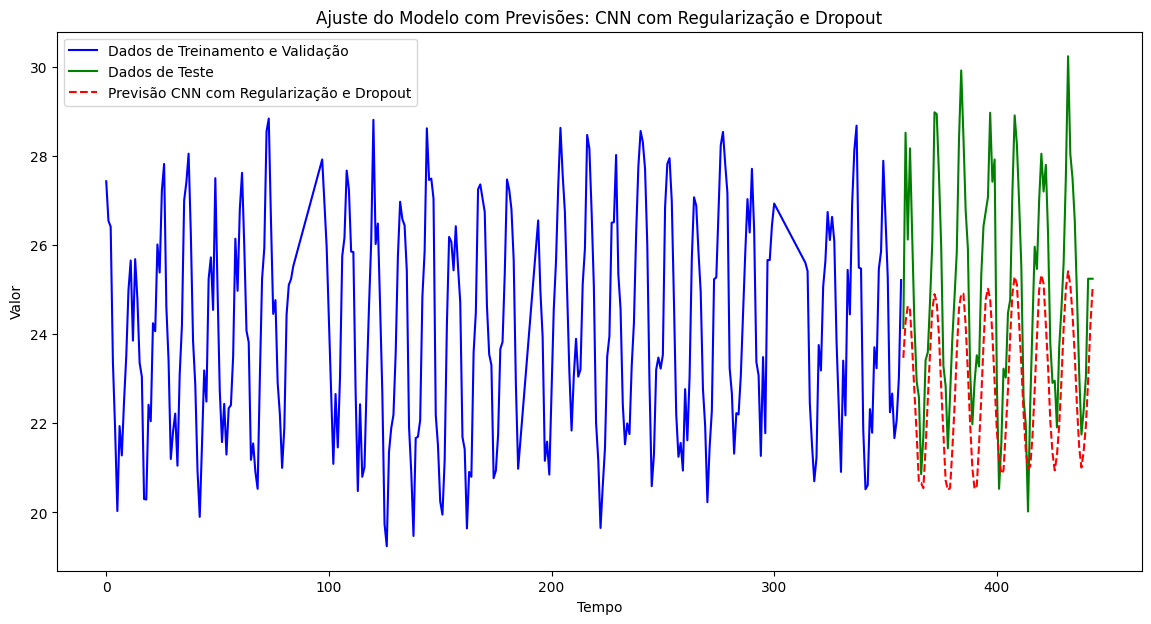

In [119]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

def plot_fit_with_predictions(train_valid_data, y_test, y_pred, model_name):
    plt.figure(figsize=(14, 7))
    
    # Plot dos dados de treino e validação
    plt.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
    
    # Plot dos dados de teste
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
    
    # Plot das previsões
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
    
    plt.title(f"Ajuste do Modelo com Previsões: {model_name}")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

# Plot do ajuste e previsão para cada modelo
plot_fit_with_predictions(train_valid_data, Y_test, predictions_simple, "CNN Padrão")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_reg, "CNN com Regularização")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_drop, "CNN com Dropout")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_regdrop, "CNN com Regularização e Dropout")